# Zach's Karate Club

In this notebook we will use the Zach Karate graph to learn about graph nueral networks (GNNs), and use one to do binary classification on our graph.

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, Softmax, Sigmoid, CrossEntropyLoss, Tanh
from torch.optim import Adam
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool
import typing as T

## EDA

In [65]:
G = KarateClub()
data = G[0]

In [80]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [68]:
G.num_classes, G.num_features

(4, 34)

In [44]:
nx_G = to_networkx(data, to_undirected=True)

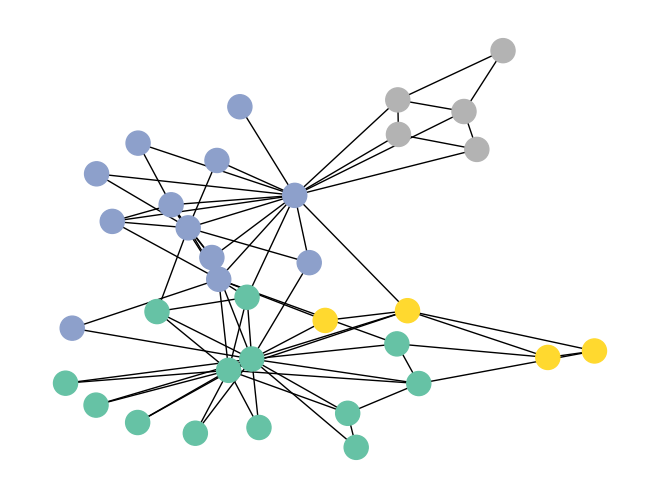

In [46]:
nx.draw(nx_G, pos=nx.spring_layout(nx_G, seed=42),
                 with_labels=False,
                 node_color=data.y,
                 cmap="Set2")

In [58]:
G[0].y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

## Building the Model

In [346]:
class KarateGCN(nn.Module):
    
    def __init__(self, num_classes: int):
        super(KarateGCN, self).__init__()
        torch.manual_seed(42)
        self.model = Sequential(
            "x, edge_index",
            [(GCNConv(G.num_features, 4),'x, edge_index -> x1'),
             Tanh(),
            (GCNConv(4, 2),'x1, edge_index -> x2'),
            Tanh(),
            Linear(2, num_classes)])
    

    def forward(self, data):
        out = self.model(data.x, data.edge_index)
        return out
        

## Training Function

In [327]:
def train(data: KarateClub, 
          model: nn.Module, 
          num_epochs: int, 
          criterion=None, 
          optimizer=None,
          ) -> float:

    def fpass(data: KarateClub, criterion, optimizer) -> T.Tuple:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        return loss

    losses = []
    criterion = CrossEntropyLoss() if criterion is None else criterion
    optimizer = Adam(model.parameters(), lr=0.01) if optimizer is None else optimizer
    for _ in range(num_epochs):
        loss = fpass(data, criterion, optimizer)
        losses.append(loss.item())
    return losses

## Plotting Function

In [328]:
def plot(losses):
    plt.title("Losses over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.plot(losses, marker='o')
    plt.show()

## Experiments

### 1. Model one w/o softmax

In [347]:
model = KarateGCN(G.num_classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
G = G.to(device)

In [348]:
print(model)

KarateGCN(
  (model): Sequential(
    (0) - GCNConv(34, 4): x, edge_index -> x1
    (1) - Tanh(): x1 -> x1
    (2) - GCNConv(4, 2): x1, edge_index -> x2
    (3) - Tanh(): x2 -> x2
    (4) - Linear(in_features=2, out_features=4, bias=True): x2 -> x2
  )
)


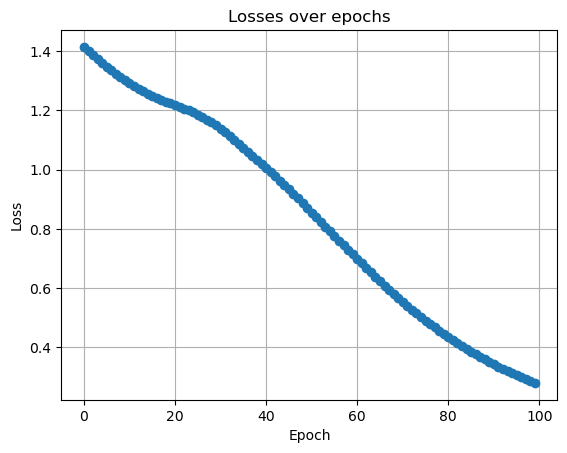

In [349]:
losses = train(data=G, model=model, num_epochs=100)
plot(losses)

#### Experiment 1 comments

Given linear nature of improvement, it could stand more epochs or perhaps a higher learning rate. Likely not deep enough, however.

### 2. Model with Tanh

In [350]:
class KarateModelTanh(nn.Module):

    def __init__(self, num_classes: int):
        super(KarateModelTanh, self).__init__()
        torch.manual_seed(42)
        self.model = Sequential(
            "x, edge_index",
            [(GCNConv(G.num_features, 4),'x, edge_index -> x1'),
             Tanh(),
            (GCNConv(4, 2),'x1, edge_index -> x2'),
            Tanh(),
            Linear(2, num_classes)])
    
    def forward(self, data):
        out = self.model(data.x, data.edge_index)
        return out

In [351]:
model2 = KarateModelTanh(G.num_classes)
model2.to(device)

KarateModelTanh(
  (model): Sequential(
    (0) - GCNConv(34, 4): x, edge_index -> x1
    (1) - Tanh(): x1 -> x1
    (2) - GCNConv(4, 2): x1, edge_index -> x2
    (3) - Tanh(): x2 -> x2
    (4) - Linear(in_features=2, out_features=4, bias=True): x2 -> x2
  )
)

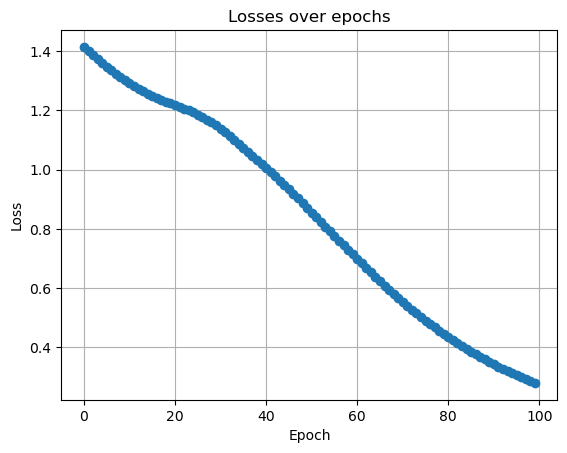

In [352]:
losses2 = train(data=G, model=model2, num_epochs=100)
plot(losses2)

#### Experiment 2 Comments

Little to no improvement by switching activation functions.

### 3. Deeper Tanh Model

In [371]:
class KarateModelDeeperTanh(nn.Module):

    def __init__(self, num_classes: int):
        super(KarateModelDeeperTanh, self).__init__()
        torch.manual_seed(42)
        self.embed = Sequential(
            "x, edge_index",
            [(GCNConv(G.num_features, 17),'x, edge_index -> x1'),
             Tanh(),
            (GCNConv(17, 10),'x1, edge_index -> x2'),
            Tanh()])
        self.classifer = Linear(10, num_classes)
    
    def forward(self, data):
        embeddings = self.embed(data.x, data.edge_index)
        out = self.classifer(embeddings)
        return out

    def get_embeddings(self, data):
        return self.embed(data.x, data.edge_index)

In [363]:
model3 = KarateModelDeeperTanh(G.num_classes)
model3.to(device)

KarateModelDeeperTanh(
  (embed): Sequential(
    (0) - GCNConv(34, 17): x, edge_index -> x1
    (1) - Tanh(): x1 -> x1
    (2) - GCNConv(17, 10): x1, edge_index -> x2
    (3) - Tanh(): x2 -> x2
  )
  (classifer): Linear(in_features=10, out_features=4, bias=True)
)

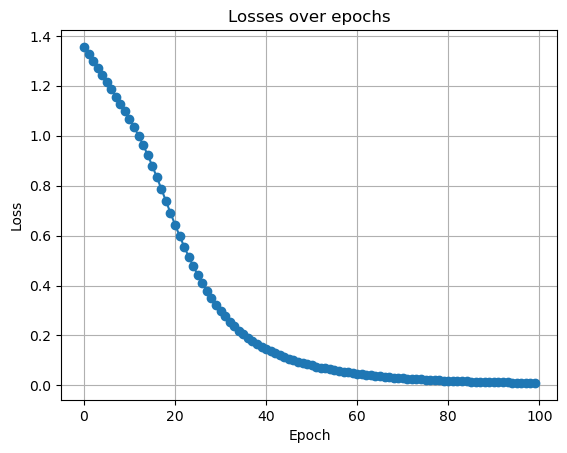

In [364]:
losses3 = train(data=G, model=model3, num_epochs=100)
plot(losses3)

#### Experiment 4 Comments

Loss decreases more rapidly than the previous models. It reaches a level near 0 at 100 epocsh, this mode this skillfull. 

### Embeddings of Model 3

In [367]:
embeddings = model3.get_embeddings(G)


In [370]:
embeddings.shape

torch.Size([34, 10])

#### TODO: Add umap dimenonality reduction to visualize. 